# This notebook aims to identify sections of audio containing target vocalization, and sections which do not contain the target vocalization. 

__proxy for target vocalisation:__ 
- Audio from a section of a recording contianing target vocalizaition, and taken from within the same timestamp as the tag. 
- Audio from a recording with tagging method 'no restrictions' AND taken from within tag timestamp of the target species. 

__proxys for NOT target vocalization__
- Audio from a recording with tagging method '1SPM' AND there is no target species tag in the recording
- Audio from a recording with tagging method '1SPM' AND there is an target species tag in the recording AND the sample is taken from before the start of the target species tag. 
- Audio from a recording with tagging method 'no restrictions' AND taken from inbetween tags of the target species. 

In [1]:
import sys
from pathlib import Path
import pandas as pd
BASE_PATH = Path.cwd().parents[1]
sys.path.append(str(BASE_PATH / "src" / "data"))  # for clean_csv and train_test_split
sys.path.append(str(BASE_PATH / "src"))  # for utils
from utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_pickle(BASE_PATH / "data"/"processed" / "train_set" / "train_set.pkl")
df_lite = df[keep_cols]
osfls = df_lite.loc[df.species_code == 'OSFL']

### What's the distribution of the different tagging methods?

In [4]:
df.task_method.value_counts(dropna=False)

task_method
1SPT                        201904
1SPM                        178249
NaN                          50291
1SPM Audio/Visual hybrid      2530
Name: count, dtype: int64

#### 1SPT = 1 sample per task <br> 1SPM = 1 sample per minute <br> NaN = no restrictions (assume this is the case for all NaNs) <br> 1SPM treat as 1SPM
- If the tagging method is 1SPT then the time interval is the duration of the recording.
- In each case, the audio before the onset of the target species vocalization can be treated as audio which does not contain the target audio. 
- In the 1SPM recordings, there are additional sources of the negative target, found between the start of each minute, and the onset of the target vocalization within that minute. 
- Initially the two classes will be treated the same, since audio for the null class isn't scarce. 

### What about the 'None' method?
- The 'None' method, or sections of the dataframe without a string value for the tagging method, are tasks without a restriction on the number of tags. These can be used as a source of positive and negative class recordigs. 



## How many recording files are there in the training set?

In [5]:
unique_recordings = df.recording_id.unique()
recordings_containing_target_species = osfls.recording_id.unique()
print(f"{unique_recordings.shape} unique recordings, {recordings_containing_target_species.shape} recordings with the target species present.")

(54416,) unique recordings, (2967,) recordings with the target species present.


In [6]:
df.columns

Index(['Unnamed: 0', 'organization', 'project', 'project_id', 'location',
       'location_id', 'recording_date_time', 'recording_id', 'task_method',
       'task_id', 'aru_task_status', 'species_code', 'species_common_name',
       'species_scientific_name', 'species_class', 'detection_time',
       'task_duration', 'tag_duration', 'min_tag_freq', 'max_tag_freq',
       'tag_id', 'individual_order', 'vocalization', 'abundance', 'tag_rating',
       'tag_is_verified', 'clip_channel_used', 'observer', 'observer_id',
       'verifier_id', 'left_full_freq_tag_rms_peak_dbfs',
       'left_full_freq_tag_rms_trough_dbfs', 'left_full_freq_tag_pk_count',
       'left_full_freq_tag_dc_offset', 'left_full_freq_tag_min_level',
       'left_full_freq_tag_max_level', 'left_full_freq_tag_peak_level_dbfs',
       'left_freq_filter_tag_rms_peak_dbfs',
       'left_freq_filter_tag_rms_trough_dbfs', 'left_freq_filter_tag_pk_count',
       'left_freq_filter_tag_dc_offset', 'left_freq_filter_tag_min_level

### Look at how to group df by recording and keep the other info
- recording ids and urls are all the same for each tag entry in the database. 
- It would be useful to have the database indexed by recording ID, and have the species tag, clip start/stop time etc stored as a list per recording. That way we could see the timestamps of all the clips for one recording. 

- Using an aggregate function, we can pass a dictionary into the groupby function so that different columns are grouped differently. This way we can end up with a list of all the target species start stop times per recording. 

###### we want to keep the following columns when working with the recordings:
-


In [7]:
# column name : aggregation method
recordings_metadata_dict = {
    "recording_url": "first",
    "task_method": "first",
    "project": "first",
    "detection_time": lambda x: list(x),
    "tag_duration": lambda x: list(x),
    "latitude": "first",
    "longitude": "first",
    "file_type": "first",
}

In [8]:
target_species = 'OSFL'
filtered_df = df.loc[df.species_code == target_species]
grouped = filtered_df.groupby('recording_id').agg(recordings_metadata_dict)
grouped.head()

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type
recording_id,,,,,,,,
4396,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[27.28, 95.9]","[0.83, 1.18]",57.292989,-111.412116,mp3
4399,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[32.63, 82.51]","[1.33, 1.11]",57.467246,-111.215322,mp3
4427,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[106.56, 122.66]","[1.0, 0.84]",57.302163,-111.376885,mp3
4429,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[31.11, 74.7, 139.78]","[1.38, 2.19, 1.29]",57.302163,-111.376885,mp3
4446,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[13.63, 74.88, 126.6]","[1.05, 0.89, 0.8]",57.482905,-111.378761,mp3


# index by filename for compatibility with opensoundscape

- filenames are formatted <br>
`recording-<recording_id>.<file_type>`

In [9]:
recording_path = BASE_PATH / "data" / "raw" / "recordings" / "OSFL"
grouped['filename'] = grouped.apply(lambda row: 'recording-' + str(row.name) + '.' + row.file_type, axis=1)
# prepend path to the filename column
grouped['path'] = grouped.apply(lambda row: recording_path / row.filename, axis=1)
grouped['relative_path'] = grouped.apply(lambda row: Path('../../data/raw/recordings/OSFL') / row.filename, axis=1)
grouped['filename'].iloc[0]

'recording-4396.mp3'

In [10]:
grouped = grouped.set_index('relative_path')


In [11]:
grouped.head()

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,filename,path
relative_path,,,,,,,,,,
../../data/raw/recordings/OSFL/recording-4396.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[27.28, 95.9]","[0.83, 1.18]",57.292989,-111.412116,mp3,recording-4396.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4399.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[32.63, 82.51]","[1.33, 1.11]",57.467246,-111.215322,mp3,recording-4399.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4427.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[106.56, 122.66]","[1.0, 0.84]",57.302163,-111.376885,mp3,recording-4427.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4429.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[31.11, 74.7, 139.78]","[1.38, 2.19, 1.29]",57.302163,-111.376885,mp3,recording-4429.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4446.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[13.63, 74.88, 126.6]","[1.05, 0.89, 0.8]",57.482905,-111.378761,mp3,recording-4446.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...


# First let's build a dataset by downloading only the recordings which contain the target species
### This dataset will also be accompanied by a dataframe with the file path as its index. 

In [12]:
# get a list of the files that have already been downloaded
downloaded_recordings = [file.name for file in (recording_path.glob('*'))]
df_downloaded_recordings = grouped.loc[grouped.filename.isin(downloaded_recordings)]
df_not_downloaded = grouped.loc[~grouped.filename.isin(downloaded_recordings)]
df_not_downloaded.head()

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,filename,path
relative_path,,,,,,,,,,
../../data/raw/recordings/OSFL/recording-4396.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[27.28, 95.9]","[0.83, 1.18]",57.292989,-111.412116,mp3,recording-4396.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4399.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[32.63, 82.51]","[1.33, 1.11]",57.467246,-111.215322,mp3,recording-4399.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4427.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[106.56, 122.66]","[1.0, 0.84]",57.302163,-111.376885,mp3,recording-4427.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4429.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[31.11, 74.7, 139.78]","[1.38, 2.19, 1.29]",57.302163,-111.376885,mp3,recording-4429.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4446.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[13.63, 74.88, 126.6]","[1.05, 0.89, 0.8]",57.482905,-111.378761,mp3,recording-4446.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...


In [13]:
# import urllib
# req = urllib.request.Request(df.recording_url.iloc[0], method='HEAD')
# f = urllib.request.urlopen(req)
# f.status
# f.headers['Content-Length']

# TODO: reduce scope of download recordings program. It should just
- Take a list of URLs
- download them and save them to disk
- The rest of the logic (filtering for species code) can be done by another piece of logic separeate from the downloader. 
- Note opensoundscape provides a `download_url` funciton in Audio, and a `save` method for Audio classes

In [14]:
n = 0 # number of recordings to download

import download_recordings
audio_save_path = Path(BASE_PATH / "data" / "raw" / "recordings" / "OSFL")
audio_save_path.mkdir(parents=True, exist_ok=True)
download_recordings.from_url(df_not_downloaded, 'recording_url', audio_save_path, target = None, n=0)


downloading 0 clips
skipped 0 previously downloaded files


# use opensoundscape methods to step through recording at intervals

In [15]:
import opensoundscape as oss

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### AudioSplittingDataset makes a set of clips with all the same labels. 
- This isn't ideal for the task of applying multiple classes to segments of one long recording.


In [16]:
pre=oss.SpectrogramPreprocessor(sample_duration=3.0)

In [17]:
training_recording = pd.DataFrame(index=['../../data/raw/recordings/OSFL/recording-100034.mp3'])
splitting_dataset = oss.AudioSplittingDataset(training_recording, pre, overlap_fraction = 0.5)
splitting_dataset.bypass_augmentations=True
tensors = [splitting_dataset[i].data for i in range(3)]

len(splitting_dataset)
splitting_dataset.label_df[:10]

Empty DataFrame
Columns: []
Index: [(../../data/raw/recordings/OSFL/recording-100034.mp3, 0.0, 3.0), (../../data/raw/recordings/OSFL/recording-100034.mp3, 1.5, 4.5), (../../data/raw/recordings/OSFL/recording-100034.mp3, 3.0, 6.0), (../../data/raw/recordings/OSFL/recording-100034.mp3, 4.5, 7.5), (../../data/raw/recordings/OSFL/recording-100034.mp3, 6.0, 9.0), (../../data/raw/recordings/OSFL/recording-100034.mp3, 7.5, 10.5), (../../data/raw/recordings/OSFL/recording-100034.mp3, 9.0, 12.0), (../../data/raw/recordings/OSFL/recording-100034.mp3, 10.5, 13.5), (../../data/raw/recordings/OSFL/recording-100034.mp3, 12.0, 15.0), (../../data/raw/recordings/OSFL/recording-100034.mp3, 13.5, 16.5)]

In [82]:
downloaded_path_df = pd.DataFrame(df_downloaded_recordings.index).set_index('relative_path')

In [97]:
training_recordings = downloaded_path_df
pre=oss.SpectrogramPreprocessor(sample_duration=3.0)
splitting_dataset = oss.AudioSplittingDataset(training_recordings, pre, overlap_fraction = 0)


In [84]:
import numpy as np

In [127]:
all_clips = splitting_dataset.label_df.reset_index()
all_clips.sample(5)

,file,start_time,end_time
4633,../../data/raw/recordings/OSFL/recording-10431...,63.0,66.0
20739,../../data/raw/recordings/OSFL/recording-53829...,0.0,3.0
20073,../../data/raw/recordings/OSFL/recording-48792...,99.0,102.0
23583,../../data/raw/recordings/OSFL/recording-55343...,6.0,9.0
25864,../../data/raw/recordings/OSFL/recording-55563...,9.0,12.0


In [153]:
df_with_splits = all_clips.merge(df_downloaded_recordings, left_on='file', right_index=True)
df_with_splits


,file,start_time,end_time,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,filename,path
0,../../data/raw/recordings/OSFL/recording-4684.mp3,0.0,3.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
1,../../data/raw/recordings/OSFL/recording-4684.mp3,3.0,6.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
2,../../data/raw/recordings/OSFL/recording-4684.mp3,6.0,9.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
3,../../data/raw/recordings/OSFL/recording-4684.mp3,9.0,12.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
4,../../data/raw/recordings/OSFL/recording-4684.mp3,12.0,15.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29887,../../data/raw/recordings/OSFL/recording-82901...,165.0,168.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[12.0],[0.64],51.675510,-115.329920,flac,recording-829015.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...
29888,../../data/raw/recordings/OSFL/recording-82901...,168.0,171.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[12.0],[0.64],51.675510,-115.329920,flac,recording-829015.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...
29889,../../data/raw/recordings/OSFL/recording-82901...,171.0,174.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[12.0],[0.64],51.675510,-115.329920,flac,recording-829015.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...
29890,../../data/raw/recordings/OSFL/recording-82901...,174.0,177.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[12.0],[0.64],51.675510,-115.329920,flac,recording-829015.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...


In [174]:
df_with_splits.detection_time

0        [8.44, 74.48, 132.45]
1        [8.44, 74.48, 132.45]
2        [8.44, 74.48, 132.45]
3        [8.44, 74.48, 132.45]
4        [8.44, 74.48, 132.45]
                 ...          
29887                   [12.0]
29888                   [12.0]
29889                   [12.0]
29890                   [12.0]
29891                   [12.0]
Name: detection_time, Length: 29892, dtype: object

# This method only gives a positive label if the tag falls entirely within the clip window. Should include partials too. 

In [177]:

df_with_splits['target_presence'] = df_with_splits.apply(
    lambda row: np.any(
        (np.array(row['detection_time']) >= row['start_time']) & 
        (np.array(row['detection_time']) + np.array(row['tag_duration']) <= row['end_time'])
    ), 
    axis=1
).astype(int)


In [180]:
df_with_splits.loc[df_with_splits.target_presence == 1].sample(5)

,file,start_time,end_time,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,filename,path,target_presence
18267,../../data/raw/recordings/OSFL/recording-32108...,18.0,21.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPT,Bioacoustic Unit Digital Point Counts,[18.28],[0.99],49.911420,-114.505110,flac,recording-321080.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...,1
17089,../../data/raw/recordings/OSFL/recording-29667...,21.0,24.0,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,1SPM,CWS-Ontario Birds of James Bay Lowlands 2021,"[4.66, 18.86, 21.2]","[0.91, 0.85, 1.0]",52.874200,-85.198700,mp3,recording-296671.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,1
7415,../../data/raw/recordings/OSFL/recording-25603...,30.0,33.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Bayne-OSFL-BU-AnyYr 2021,"[1.83, 3.78, 4.26, 7.41, 14.83, 15.83, 24.28, ...","[0.96, 0.71, 0.8, 0.96, 0.88, 0.86, 1.11, 1.45...",60.690000,-135.166410,mp3,recording-256035.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,1
819,../../data/raw/recordings/OSFL/recording-44896...,120.0,123.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Big Grids,"[4.64, 61.04, 72.55, 121.2, 157.01]","[1.65, 1.63, 1.24, 1.78, 1.2]",55.341251,-111.099205,mp3,recording-44896.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,1
24186,../../data/raw/recordings/OSFL/recording-55356...,15.0,18.0,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,1SPT,CWS-Ontario Boreal Shield-Lowlands Transition ...,[15.75],[1.13],52.193674,-87.161888,flac,recording-553568.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...,1


In [191]:
df_with_splits.set_index('file', inplace=True)

KeyError: "None of ['file'] are in the columns"

# Try re-indexing so that the file, start and end times are all indexes for a multi index


In [204]:
oss.AudioFileDataset(df_with_splits, pre).label_df

,start_time,end_time,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,filename,path,target_presence
file,,,,,,,,,,,,,
../../data/raw/recordings/OSFL/recording-4684.mp3,0.0,3.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-4684.mp3,3.0,6.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-4684.mp3,6.0,9.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-4684.mp3,9.0,12.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-4684.mp3,12.0,15.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
../../data/raw/recordings/OSFL/recording-829015.flac,165.0,168.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[12.0],[0.64],51.675510,-115.329920,flac,recording-829015.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-829015.flac,168.0,171.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[12.0],[0.64],51.675510,-115.329920,flac,recording-829015.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-829015.flac,171.0,174.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[12.0],[0.64],51.675510,-115.329920,flac,recording-829015.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0


In [202]:
splitting_dataset.bypass_augmentations=True
tensors = [splitting_dataset[i].data for i in range(3)]



In [203]:

len(splitting_dataset)
splitting_dataset.label_df[:10]

Empty DataFrame
Columns: []
Index: [(../../data/raw/recordings/OSFL/recording-4684.mp3, 0.0, 3.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 3.0, 6.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 6.0, 9.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 9.0, 12.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 12.0, 15.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 15.0, 18.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 18.0, 21.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 21.0, 24.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 24.0, 27.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 27.0, 30.0)]

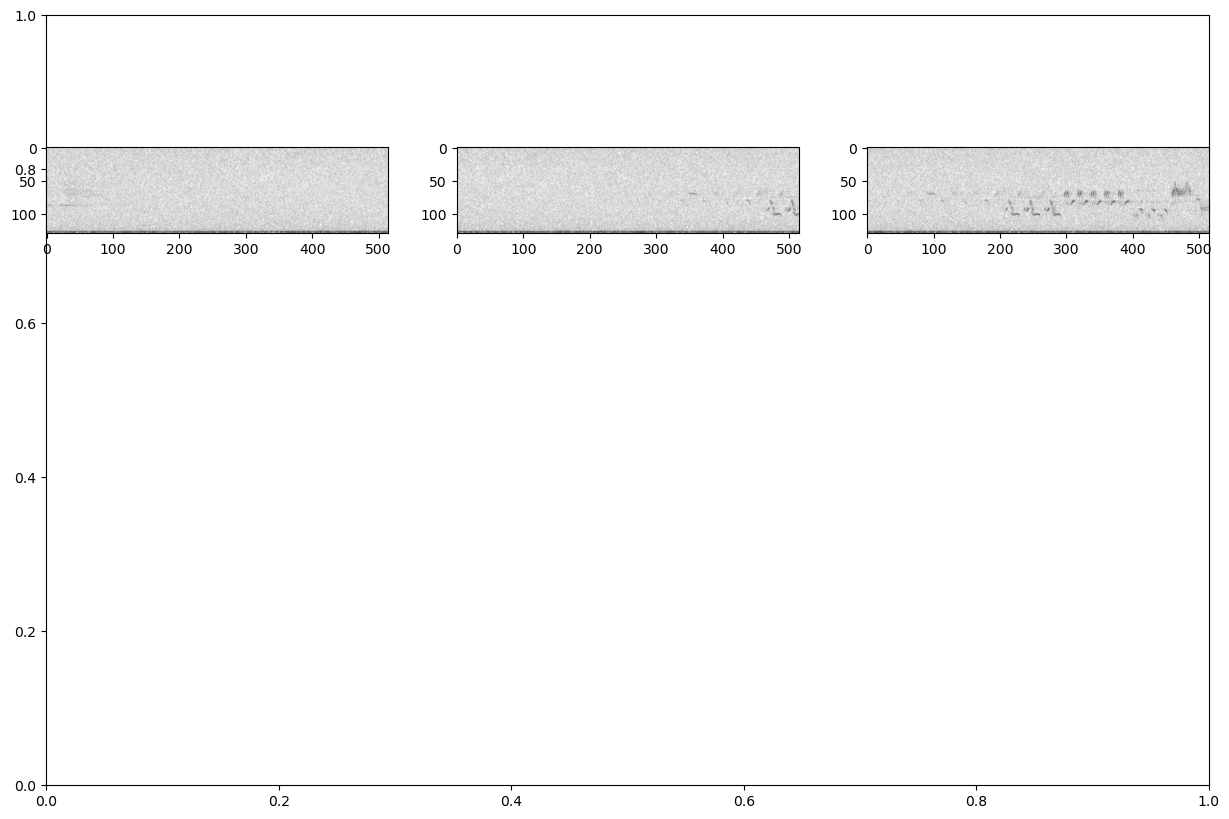

In [ ]:
# helper function for displaying a sample as an image
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
_ = show_tensor_grid(tensors,3, )



##  AudioFileDataset works on a dataframe with a multi index of (path,start_time,end_time) per clip

Check out the docstring for the class:

```python
class AudioFileDataset(torch.utils.data.Dataset):
    """Base class for audio datasets with OpenSoundscape (use in place of torch Dataset)

    Custom Dataset classes should subclass this class or its children.

    Datasets in OpenSoundscape contain a Preprocessor object which is
    responsible for the procedure of generating a sample for a given input.
    The DataLoader handles a dataframe of samples (and potentially labels) and
    uses a Preprocessor to generate samples from them.

    Args:
        samples:
            the files to generate predictions for. Can be:
            - a dataframe with index containing audio paths, OR
            - a dataframe with multi-index of (path,start_time,end_time) per clip, OR
            - a list or np.ndarray of audio file paths

            Notes for input dataframe:
             - df must have audio paths in the index.
             - If label_df has labels, the class names should be the columns, and
            the values of each row should be 0 or 1.
             - If data does not have labels, label_df will have no columns
        preprocessor:
            an object of BasePreprocessor or its children which defines
            the operations to perform on input samples

    Returns:
        sample (AudioSample object)

    Raises:
        PreprocessingError if exception is raised during __getitem__

    Effects:
        self.invalid_samples will contain a set of paths that did not successfully
            produce a list of clips with start/end times, if split_files_into_clips=True
    """
```


To get a dataframe with multi-index of (path, start_time, end_time) per clip we could use the AudioSplittingDataset to generate the clip start and end times, then make a new multi index dataset from these times combined with each recording. 

In [ ]:
bp = oss.preprocessors.BasePreprocessor(sample_duration=3.0)

In [ ]:
training_recording = pd.DataFrame(index=['../../data/raw/recordings/OSFL/recording-100034.mp3'], columns=['OSFL'], data=[[0]])

In [ ]:
splits = oss.AudioSplittingDataset(training_recording, preprocessor=bp, overlap_fraction=0.5)


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]


In [ ]:
afd = oss.AudioFileDataset(splits.label_df, bp)
afd.label_df

OSFL
file                                               start_time end_time      
../../data/raw/recordings/OSFL/recording-100034... 0.0        3.0          0
                                                   1.5        4.5          0
                                                   3.0        6.0          0
                                                   4.5        7.5          0
                                                   6.0        9.0          0
...                                                                      ...
                                                   171.0      174.0        0
                                                   172.5      175.5        0
                                                   174.0      177.0        0
                                                   175.5      178.5        0
                                                   177.0      180.0        0

[119 rows x 1 columns]

In [ ]:
downloaded_recording_df

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,filename
pathname,,,,,,,,,
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-4684.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,recording-4684.mp3
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-4704.flac,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[33.18, 62.85]","[0.95, 0.95]",57.327953,-111.339399,flac,recording-4704.flac
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-4739.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,[76.03],[1.08],57.411440,-111.217150,mp3,recording-4739.mp3
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-4830.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,[83.34],[0.81],57.384786,-111.233880,mp3,recording-4830.mp3
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-4832.flac,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[15.43, 65.18, 122.69]","[0.85, 1.25, 1.08]",57.453914,-111.432689,flac,recording-4832.flac
...,...,...,...,...,...,...,...,...,...
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-826231.flac,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[19.3],[1.05],51.897395,-115.008394,flac,recording-826231.flac
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-826265.flac,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[37.8],[0.61],51.680104,-115.332787,flac,recording-826265.flac
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-826274.flac,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[8.31],[0.68],51.678160,-115.306235,flac,recording-826274.flac
